In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

C:\Users\Asus\AppData\Local\Temp\ipykernel_25248\3339905737.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# read csv file
data = pd.read_csv('aefi.csv')

# convert the 'date' column to datetime, allowing mixed formats
data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')

# define the date range
start_date = '2021-04-15'
end_date = '2021-10-15'

# filter the data within the specified date range
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

C:\Users\Asus\AppData\Local\Temp\ipykernel_25248\3963301745.py:5: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')


In [3]:
print(data.head())
print(data.describe())
print(data.info())
print(data.columns)
print(data.shape)
print(data.isnull().sum())
print(data.dtypes)

        date      vaxtype  daily_total  daily_serious_npra  daily_nonserious  \
0 2021-01-13  astrazeneca            5                   0                 5   
1 2021-02-25       pfizer            1                   0                 1   
2 2021-02-26       pfizer            2                   0                 2   
3 2021-02-27       pfizer            4                   0                 4   
4 2021-02-28       pfizer           12                   1                11   

   daily_nonserious_npra  daily_nonserious_mysj_dose1  \
0                      5                            0   
1                      1                            0   
2                      2                            0   
3                      4                            0   
4                     11                            0   

   daily_nonserious_mysj_dose2  d1_site_pain  d1_site_swelling  ...  \
0                            0             0                 0  ...   
1                            0    

In [4]:
# Drop columns and left the selected columns
data.drop(['date','daily_nonserious','daily_nonserious_mysj_dose1',
        'daily_nonserious_mysj_dose2','d1_site_swelling',
        'd1_site_redness', 'd1_tiredness', 'd1_muscle_pain',
        'd1_joint_pain', 'd1_weakness', 'd1_vomiting', 'd1_chills',
        'd1_rash',  'd2_site_swelling', 'd2_site_redness',
        'd2_tiredness','d2_muscle_pain', 'd2_joint_pain',
        'd2_weakness', 'd2_vomiting', 'd2_chills', 'd2_rash'], axis=1, inplace=True)

print(data.columns)


Index(['vaxtype', 'daily_total', 'daily_serious_npra', 'daily_nonserious_npra',
       'd1_site_pain', 'd1_headache', 'd1_fever', 'd2_site_pain',
       'd2_headache', 'd2_fever'],
      dtype='object')


In [5]:
# check number of vaxtype in vaxtype column
print(data['vaxtype'].nunique())

# print out the vaxtype name
vaxtype_name = data['vaxtype'].unique()
print(vaxtype_name)

4
['astrazeneca' 'pfizer' 'sinovac' 'sinopharm']


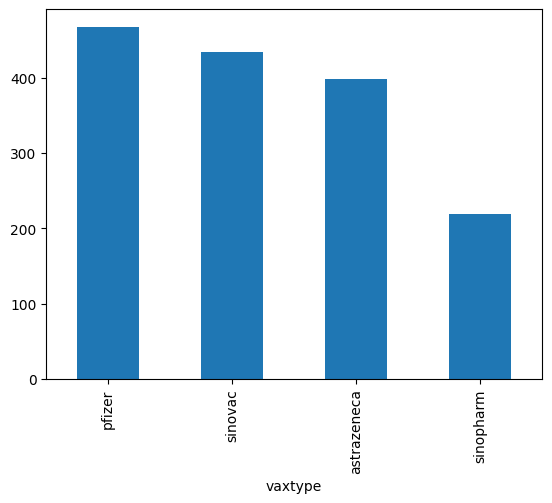

In [6]:
# check frequency of vaxtype in graph
data['vaxtype'].value_counts().plot(kind='bar')
plt.show()

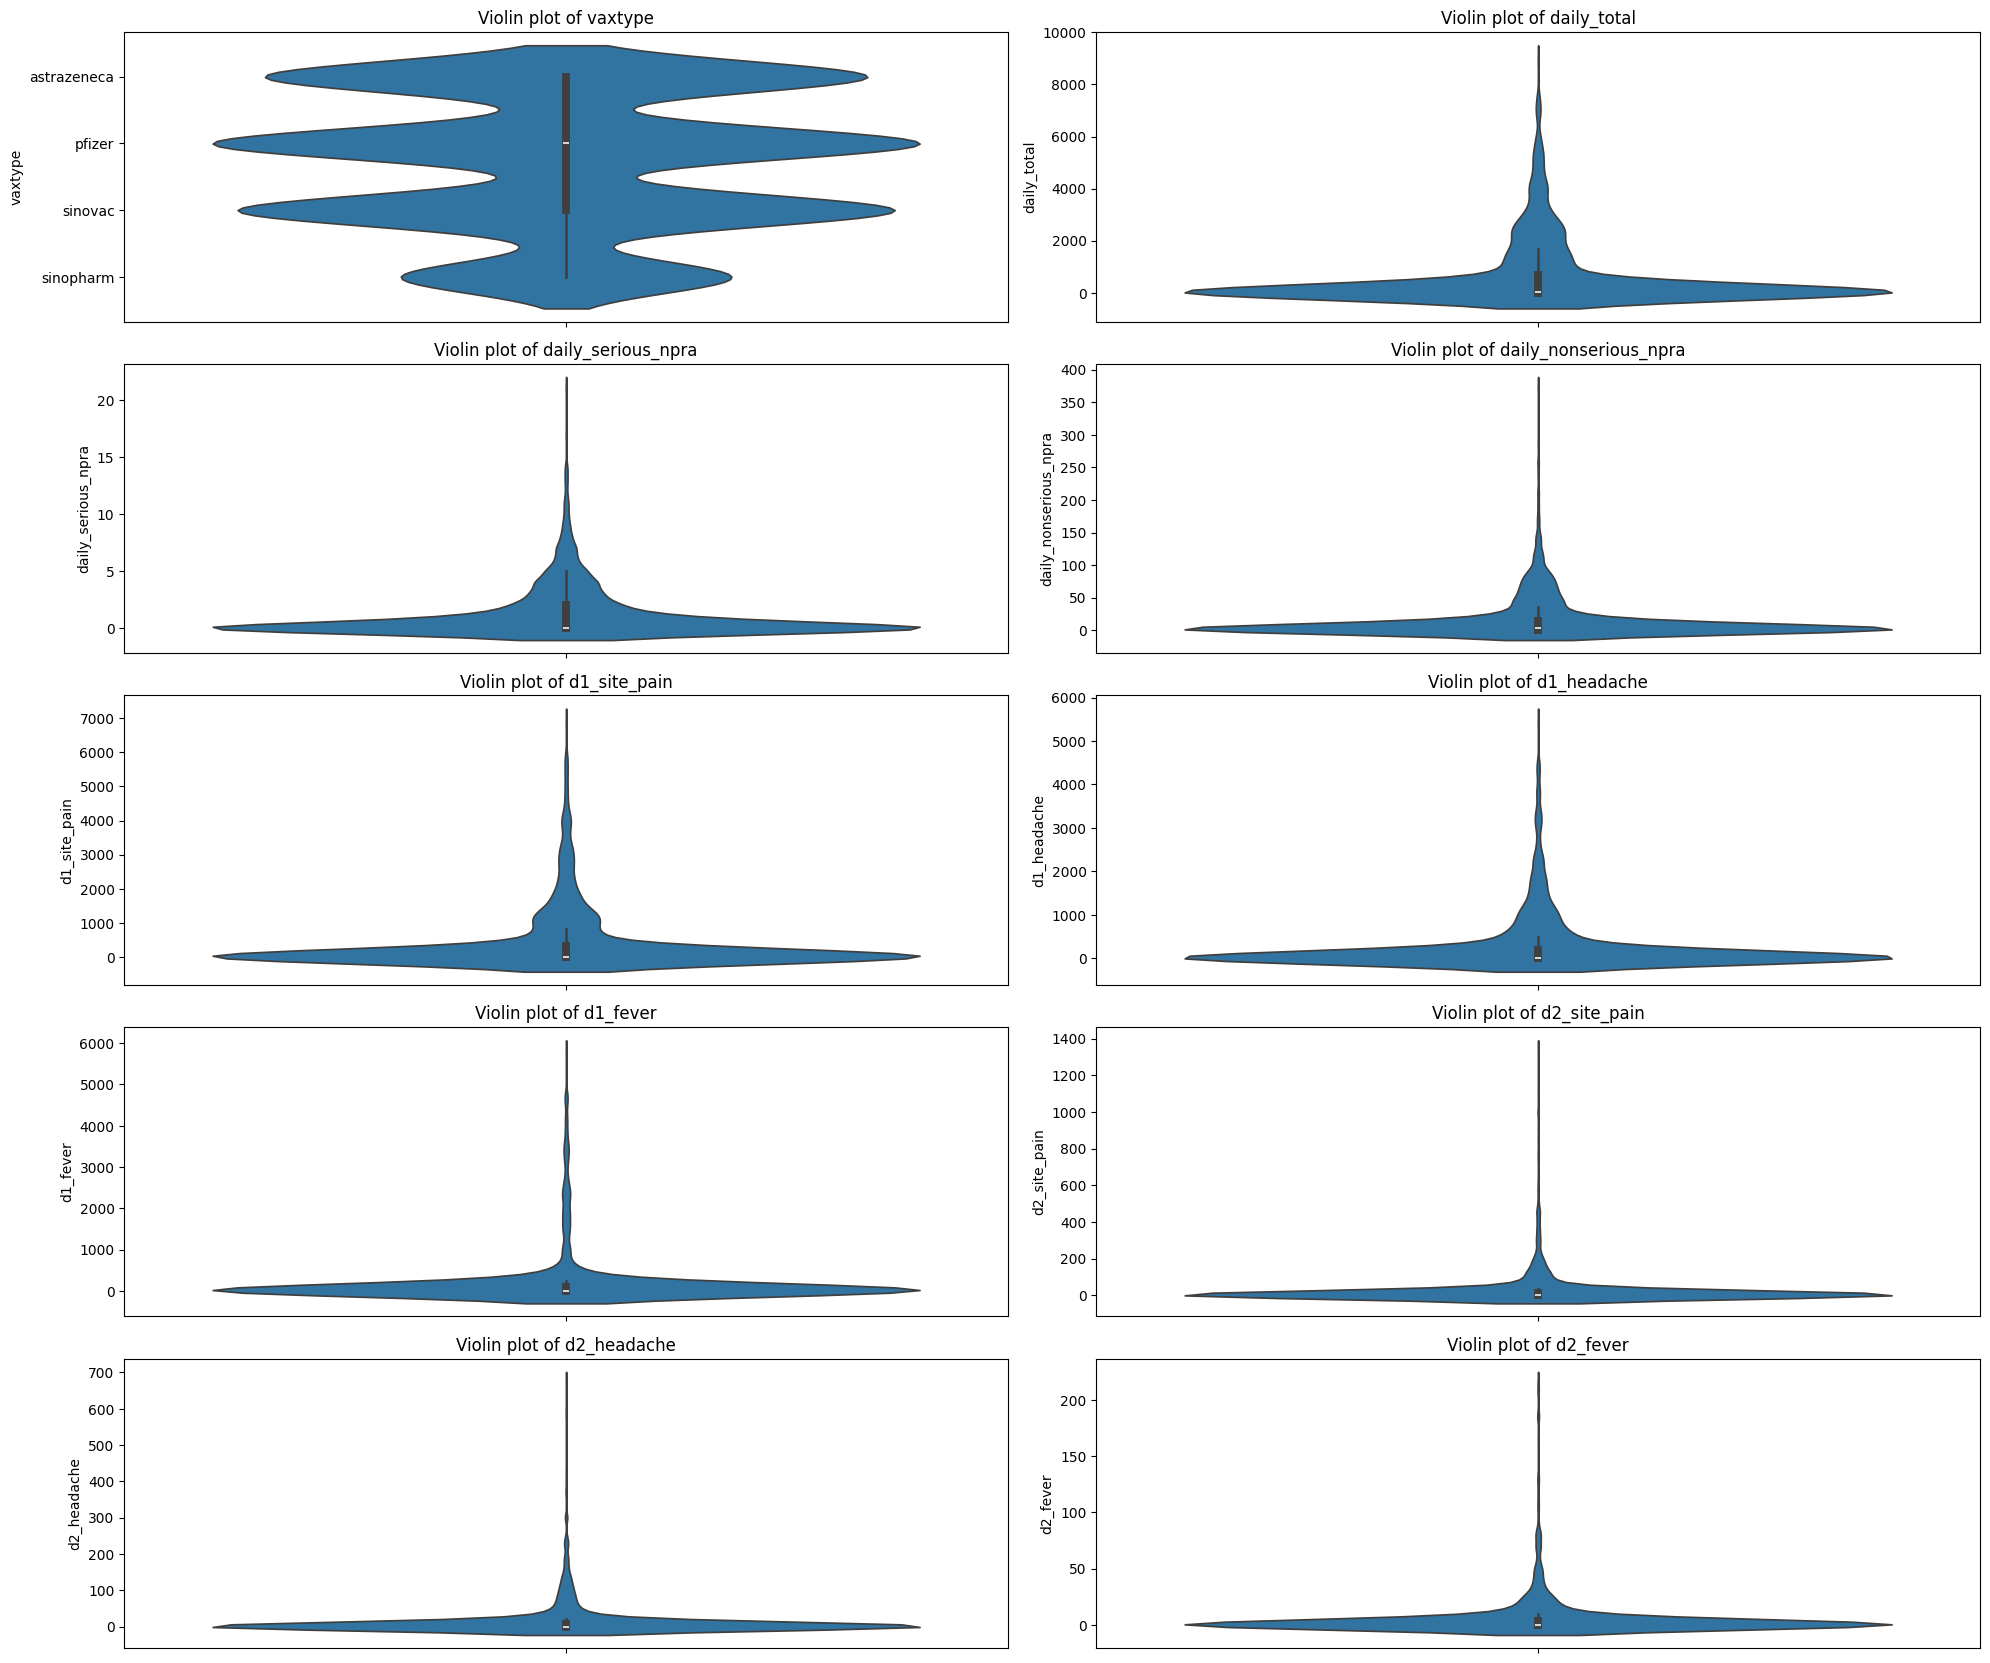

In [7]:
# violin plot to check outliers
plt.figure(figsize=(20,20))

# loop through the columns of your dataset to plot violin plots
for i, column in enumerate(data.columns, 1):
    plt.subplot(len(data.columns)//2 + 1, 2, i)  # to adjust subplot grid
    sns.violinplot(data=data[column])
    plt.title(f'Violin plot of {column}')

plt.tight_layout()
plt.show()

In [8]:
# convert the vaxtype colummn from category to numerical (alternative method/based on alphebetical order to assign numerical value)
# data['vaxtype'] = data['vaxtype'].astype('category')
# data['vaxtype'] = data['vaxtype'].cat.codes

# convert the vaxtype colummn from category to numerical
vaxtype_mapping = {'pfizer': 0, 'sinovac': 1, 'astrazeneca': 2, 'sinopharm': 3}
data['vaxtype'] = data['vaxtype'].map(vaxtype_mapping)

# check the fequency of each vaxtype
vaxtype_freq = data['vaxtype'].value_counts()
print(vaxtype_freq)

vaxtype
0    468
1    435
2    399
3    219
Name: count, dtype: int64


In [9]:
# remove Sinopharm vaxtype related rows from the dataset
data = data[data['vaxtype'] != 3]
print(data['vaxtype'].value_counts())

vaxtype
0    468
1    435
2    399
Name: count, dtype: int64


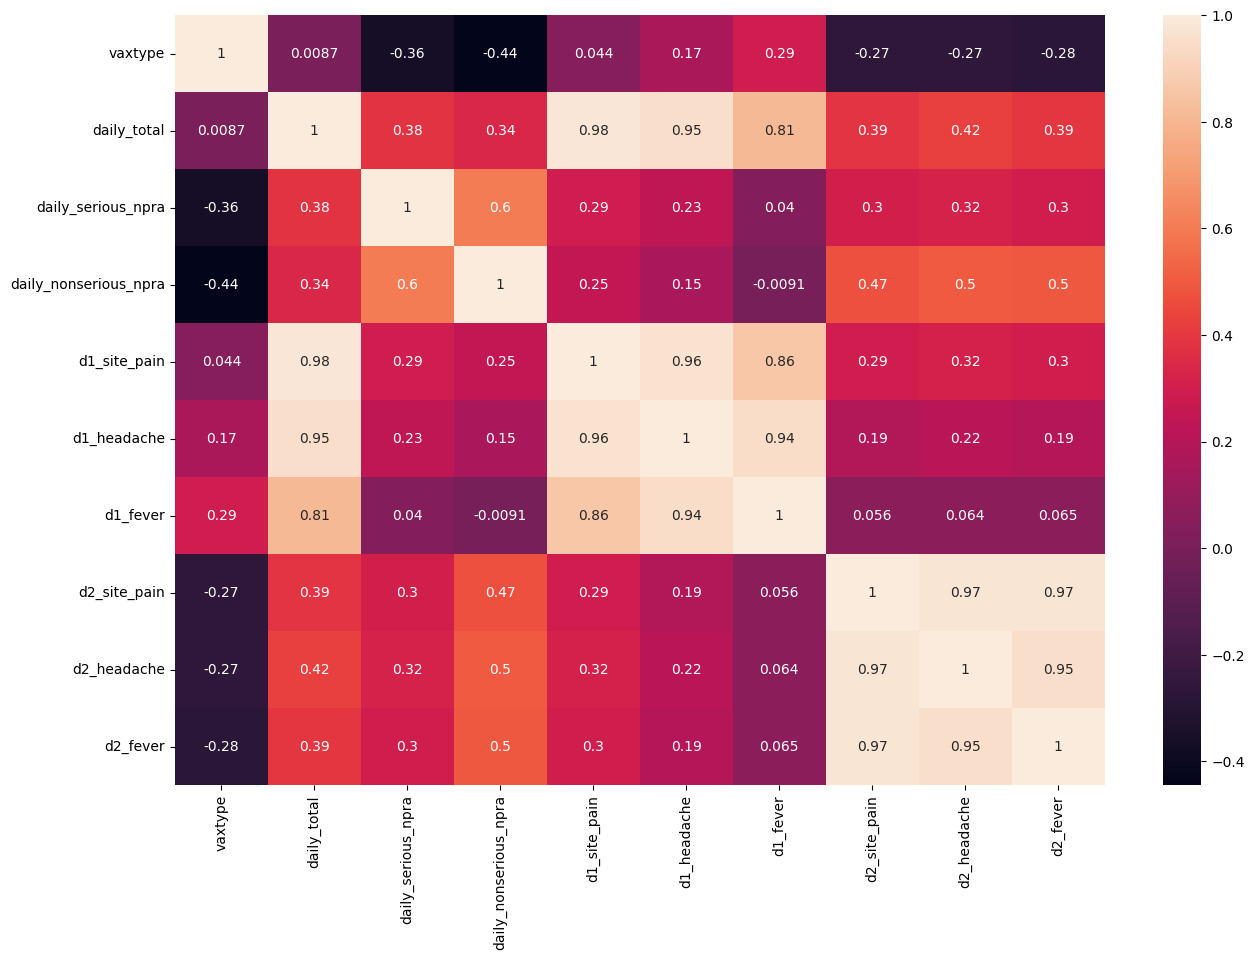

In [10]:
import seaborn as sns

# check the correlation between all the columns in the dataframe
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [11]:
# do Variance inflation factor to check for multicollinearity
def calculate_vif(data):
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return(vif)

print(calculate_vif(data))

               variables         VIF
0                vaxtype    1.297601
1            daily_total  344.337468
2     daily_serious_npra    2.796663
3  daily_nonserious_npra    2.906362
4           d1_site_pain   87.308251
5            d1_headache  371.806934
6               d1_fever   80.130662
7           d2_site_pain   40.426905
8            d2_headache   23.835989
9               d2_fever   22.339223


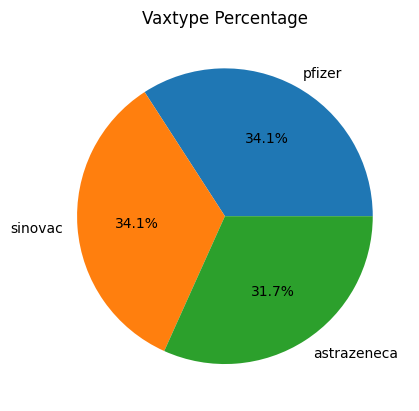

In [12]:
# use SMOTE to over-smapling the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority',random_state=42)
X = data.drop('vaxtype', axis=1)
y = data['vaxtype']
X_res, y_res = sm.fit_resample(X, y)

# check in percentage of vaxtype in piechart
vaxtype_percentage = y_res.value_counts(normalize=True)
# label the index
vaxtype_percentage.index = ['pfizer', 'sinovac', 'astrazeneca']
plt.title('Vaxtype Percentage')
plt.pie(vaxtype_percentage, labels=vaxtype_percentage.index, autopct='%1.1f%%')
plt.show()


## Data Preprocessing

In [13]:
# check for duplicates in the dataset
duplicates = data.duplicated(keep=False)
if duplicates.sum() > 0:
    # print the number of duplicates in each column
    duplicate_rows = data[duplicates]
    print("Number of duplicates in each column:")
    print(duplicate_rows.apply(lambda x: x.duplicated().sum(), axis=0))
    
    # drop duplicates
    data.drop_duplicates(inplace=True)
    print("Duplicates removed.")
else:
    print("No duplicates found.")


Number of duplicates in each column:
vaxtype                  283
daily_total              279
daily_serious_npra       283
daily_nonserious_npra    279
d1_site_pain             284
d1_headache              284
d1_fever                 284
d2_site_pain             285
d2_headache              285
d2_fever                 285
dtype: int64
Duplicates removed.


In [14]:
# check if there are any null values in the DataFrame
if data.isnull().sum().sum() > 0:
    # fill only numeric columns with their mean values 
    data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)
    print("Done filling missing values in numeric columns.")
else:
    print("No null values found.")

No null values found.


In [15]:
# split the dataset into 80% training, 10% testing and 10% validation set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# check the shape of the dataset
print("Size of the dataset:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# check the shape of the target
print("Size of the target:")
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Size of the dataset:
(1096, 9)
(137, 9)
(138, 9)
Size of the target:
(1096,)
(137,)
(138,)


In [16]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [17]:
# insert the models that you want to use in the list using this format:  models.append(('model name', Model()))
models = []   #(   __name__   ,    __Model()__  )     # you can comment(hashtag) the models below that you don't want to use
models.append(('KNN', KNeighborsClassifier(n_neighbors=51)))
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(26,26,26,1), max_iter=200, random_state=42)))
models.append(('DecisionTree', DecisionTreeClassifier(criterion='entropy', random_state=42)))
models.append(('GaussianNB', GaussianNB()))


In [18]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# train the model using training and validation data
for name, model in models:
    try:
        startTraining = time.time()   # start Training time
        model.fit(X_train, y_train)
        endTraining = time.time()     # end Training time
        print(name, 'trained,', 'Time taken:', \
            time.strftime("%H:%M:%S  ", time.gmtime(endTraining - startTraining)))
        #reset the time for next model
        startTraining = endTraining = 0
    except Exception as e:
        print("Input error:", e)

KNN trained, Time taken: 00:00:00  
MLP trained, Time taken: 00:00:00  
DecisionTree trained, Time taken: 00:00:00  
GaussianNB trained, Time taken: 00:00:00  


In [19]:
# y_pred to store the predicted values from each model
# y_pred_proba to store probabilities from each model
y_pred = []                 #for confusion matrix
y_pred_proba = []           #for ROC curve

for name, model in models:
    try:
        startPredicting = time.time()   # start predicting time
        y_pred.append(model.predict(X_val))
        y_pred_proba.append(model.predict_proba(X_val))
        endPredicting = time.time()     # end predicting time
        print(name, 'predicted,', 'Time taken:', \
              time.strftime("%H:%M:%S  ", time.gmtime(endPredicting - startPredicting)))
        #reset the time for next model
        startPredicting = endPredicting = 0
    except Exception as e:
        print("Input error:", e)

KNN predicted, Time taken: 00:00:00  
MLP predicted, Time taken: 00:00:00  
DecisionTree predicted, Time taken: 00:00:00  
GaussianNB predicted, Time taken: 00:00:00  


KNN
Accuracy:  0.572463768115942
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        48
           1       0.37      0.32      0.34        44
           2       0.59      0.63      0.61        46

    accuracy                           0.57       138
   macro avg       0.56      0.57      0.56       138
weighted avg       0.56      0.57      0.57       138

[[36  9  3]
 [13 14 17]
 [ 2 15 29]]


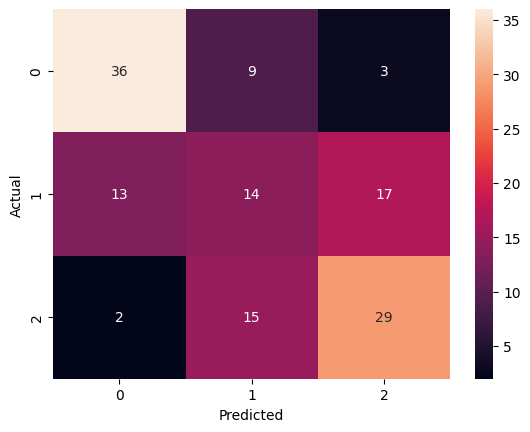

MLP
Accuracy:  0.6159420289855072
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        48
           1       0.38      0.14      0.20        44
           2       0.50      0.78      0.61        46

    accuracy                           0.62       138
   macro avg       0.58      0.60      0.56       138
weighted avg       0.59      0.62      0.57       138

[[43  3  2]
 [ 4  6 34]
 [ 3  7 36]]


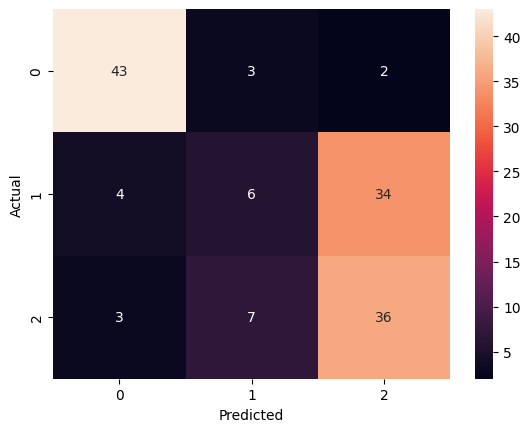

DecisionTree
Accuracy:  0.7391304347826086
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        48
           1       0.69      0.55      0.61        44
           2       0.67      0.78      0.72        46

    accuracy                           0.74       138
   macro avg       0.74      0.73      0.73       138
weighted avg       0.74      0.74      0.73       138

[[42  4  2]
 [ 4 24 16]
 [ 3  7 36]]


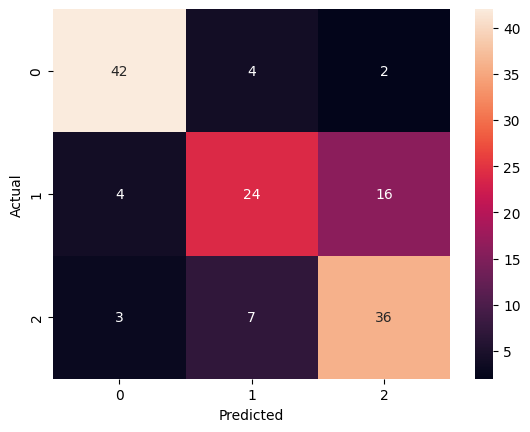

GaussianNB
Accuracy:  0.5289855072463768
              precision    recall  f1-score   support

           0       0.77      0.35      0.49        48
           1       0.34      0.36      0.35        44
           2       0.58      0.87      0.70        46

    accuracy                           0.53       138
   macro avg       0.56      0.53      0.51       138
weighted avg       0.57      0.53      0.51       138

[[17 25  6]
 [ 5 16 23]
 [ 0  6 40]]


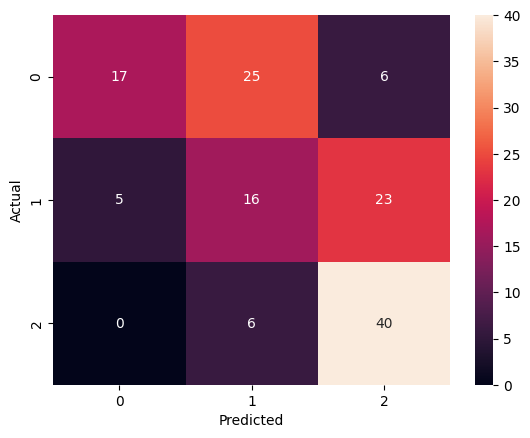

KNN
Accuracy: 0.572463768115942
AUC (macro): 0.7969125452541657
MLP
Accuracy: 0.6159420289855072
AUC (macro): 0.7972803874886454
DecisionTree
Accuracy: 0.7391304347826086
AUC (macro): 0.8384943471706432
GaussianNB
Accuracy: 0.5289855072463768
AUC (macro): 0.7484285342712859
KNN
MLP
DecisionTree
GaussianNB


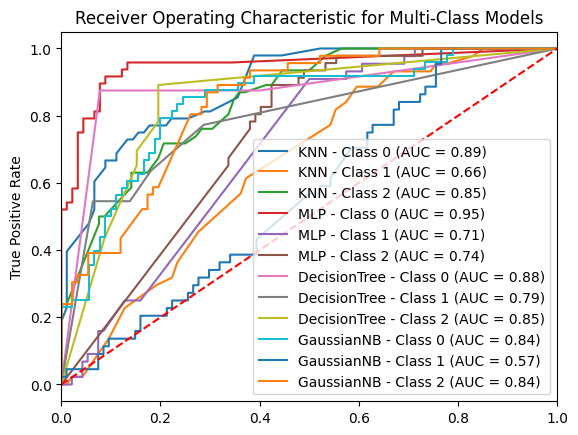

In [20]:
#  print the accuracy, classification report and confusion matrix for each model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve

accuracy = []
for i in range(len(models)):
    try:
        print(models[i][0])
        accuracy.append(accuracy_score(y_val, y_pred[i]))
        print('Accuracy: ', accuracy[i])
        print(classification_report(y_val, y_pred[i]))
        print(confusion_matrix(y_val, y_pred[i]))
        sns.heatmap(confusion_matrix(y_val, y_pred[i]), annot=True, fmt='d',)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print("Error:", e)

#auc score
from sklearn.metrics import roc_auc_score
for i in range(len(models)):
    try:
        print(models[i][0])  # Print the model name
        print('Accuracy:', accuracy[i])

        # Compute AUC for multi-class classification using one-vs-rest (OvR)
        auc = roc_auc_score(y_val, y_pred_proba[i], multi_class='ovr', average='macro')
        print('AUC (macro):', auc)
    except Exception as e:
        print(f"Error calculating AUC for model {i}: {e}")

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC/AUC
n_classes = len(set(y_val))  # Determine the number of classes in y_val
y_val_bin = label_binarize(y_val, classes=[i for i in range(n_classes)])  # Binarize y_val for multi-class

fpr = {}
tpr = {}
roc_auc = {}

# Plot ROC curve for each model and each class (one-vs-rest)
for i in range(len(models)):
    print(models[i][0])  # Print the model name
    fpr[models[i][0]] = {}
    tpr[models[i][0]] = {}
    roc_auc[models[i][0]] = {}

    for class_label in range(n_classes):  # Loop through each class
        try:
            # Calculate the ROC curve for the current class
            fpr[models[i][0]][class_label], tpr[models[i][0]][class_label], _ = roc_curve(
                y_val_bin[:, class_label], y_pred_proba[i][:, class_label]
            )
            roc_auc[models[i][0]][class_label] = auc(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label])

            # Plot the ROC curve for the current class
            plt.plot(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label],
                     label=f'{models[i][0]} - Class {class_label} (AUC = {roc_auc[models[i][0]][class_label]:0.2f})')
        except Exception as e:
            print(f"Error calculating ROC curve for class {class_label} in model {i}: {e}")

# Plot the diagonal line (reference line for random predictions)
plt.plot([0, 1], [0, 1], 'r--')

# Set the plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Models')
plt.legend(loc="lower right")
plt.show()


In [21]:
# use trained model on TEST data
y_pred2 = []                 #for confusion matrix
y_pred_proba2 = []           #for ROC curve
for name, model in models:
    startPredicting2 = time.time()   # start predicting time
    y_pred2.append(model.predict(X_test))
    y_pred_proba2.append(model.predict_proba(X_test))
    endPredicting2 = time.time()     # end predicting time
    print(name, 'predicted,', 'Time taken:', \
          time.strftime("%H:%M:%S  ", time.gmtime(endPredicting2 - startPredicting2)))
    #reset time
    startPredicting2 = endPredicting2 = 0

KNN predicted, Time taken: 00:00:00  
MLP predicted, Time taken: 00:00:00  
DecisionTree predicted, Time taken: 00:00:00  
GaussianNB predicted, Time taken: 00:00:00  


KNN
Accuracy:  0.5912408759124088
              precision    recall  f1-score   support

           0       0.65      0.74      0.70        43
           1       0.37      0.38      0.37        40
           2       0.72      0.63      0.67        54

    accuracy                           0.59       137
   macro avg       0.58      0.58      0.58       137
weighted avg       0.60      0.59      0.59       137

[[32  9  2]
 [14 15 11]
 [ 3 17 34]]


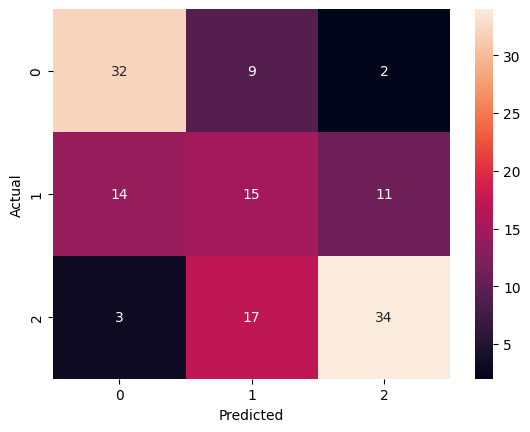

MLP
Accuracy:  0.5985401459854015
              precision    recall  f1-score   support

           0       0.71      0.86      0.78        43
           1       0.15      0.05      0.08        40
           2       0.60      0.80      0.68        54

    accuracy                           0.60       137
   macro avg       0.49      0.57      0.51       137
weighted avg       0.50      0.60      0.54       137

[[37  4  2]
 [11  2 27]
 [ 4  7 43]]


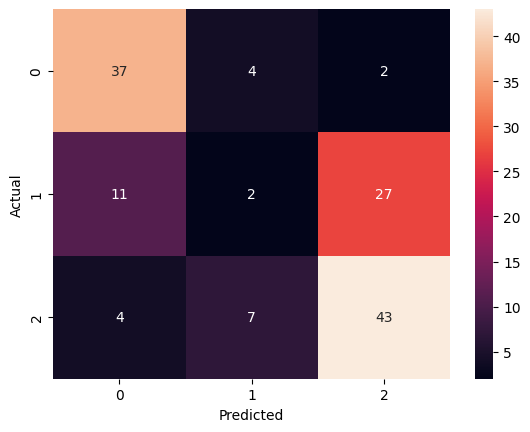

DecisionTree
Accuracy:  0.8029197080291971
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        43
           1       0.70      0.65      0.68        40
           2       0.83      0.81      0.82        54

    accuracy                           0.80       137
   macro avg       0.79      0.80      0.80       137
weighted avg       0.80      0.80      0.80       137

[[40  3  0]
 [ 5 26  9]
 [ 2  8 44]]


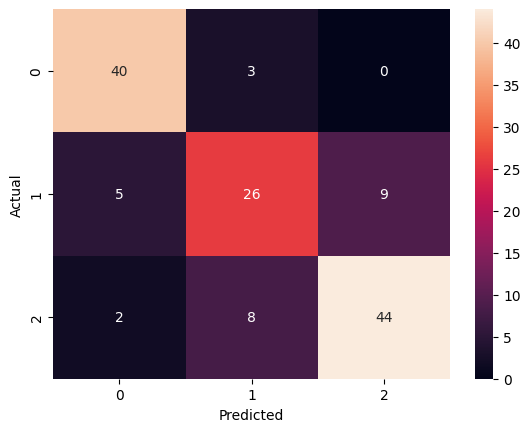

GaussianNB
Accuracy:  0.5985401459854015
              precision    recall  f1-score   support

           0       0.84      0.49      0.62        43
           1       0.41      0.42      0.42        40
           2       0.62      0.81      0.70        54

    accuracy                           0.60       137
   macro avg       0.62      0.58      0.58       137
weighted avg       0.63      0.60      0.59       137

[[21 14  8]
 [ 4 17 19]
 [ 0 10 44]]


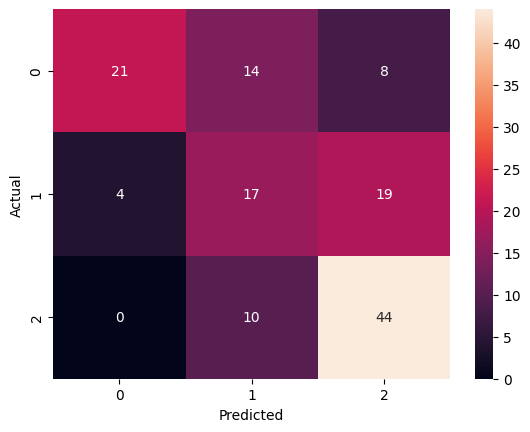

KNN
Accuracy: 0.5912408759124088
AUC (macro): 0.8009092784999133
MLP
Accuracy: 0.5985401459854015
AUC (macro): 0.7685055690894216
DecisionTree
Accuracy: 0.8029197080291971
AUC (macro): 0.8802166694068552
GaussianNB
Accuracy: 0.5985401459854015
AUC (macro): 0.7920604967654966
KNN
MLP
DecisionTree
GaussianNB


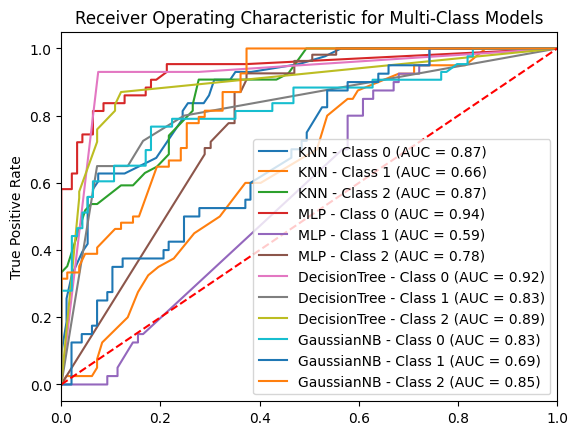

In [22]:
#  print the accuracy, classification report and confusion matrix for each model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve

accuracy = []
for i in range(len(models)):
    try:
        print(models[i][0])
        accuracy.append(accuracy_score(y_test, y_pred2[i]))
        print('Accuracy: ', accuracy[i])
        print(classification_report(y_test, y_pred2[i]))
        print(confusion_matrix(y_test, y_pred2[i]))
        sns.heatmap(confusion_matrix(y_test, y_pred2[i]), annot=True, fmt='d',)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    except Exception as e:
        print("Error:", e)

#auc score
from sklearn.metrics import roc_auc_score
for i in range(len(models)):
    try:
        print(models[i][0])  # Print the model name
        print('Accuracy:', accuracy[i])

        # Compute AUC for multi-class classification using one-vs-rest (OvR)
        auc = roc_auc_score(y_test, y_pred_proba2[i], multi_class='ovr', average='macro')
        print('AUC (macro):', auc)
    except Exception as e:
        print(f"Error calculating AUC for model {i}: {e}")

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC/AUC
n_classes = len(set(y_test))  # Determine the number of classes in y_test
y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])  # Binarize y_test for multi-class

fpr = {}
tpr = {}
roc_auc = {}

# Plot ROC curve for each model and each class (one-vs-rest)
for i in range(len(models)):
    print(models[i][0])  # Print the model name
    fpr[models[i][0]] = {}
    tpr[models[i][0]] = {}
    roc_auc[models[i][0]] = {}

    for class_label in range(n_classes):  # Loop through each class
        try:
            # Calculate the ROC curve for the current class
            fpr[models[i][0]][class_label], tpr[models[i][0]][class_label], _ = roc_curve(
                y_test_bin[:, class_label], y_pred_proba2[i][:, class_label]
            )
            roc_auc[models[i][0]][class_label] = auc(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label])

            # Plot the ROC curve for the current class
            plt.plot(fpr[models[i][0]][class_label], tpr[models[i][0]][class_label],
                     label=f'{models[i][0]} - Class {class_label} (AUC = {roc_auc[models[i][0]][class_label]:0.2f})')
        except Exception as e:
            print(f"Error calculating ROC curve for class {class_label} in model {i}: {e}")

# Plot the diagonal line (reference line for random predictions)
plt.plot([0, 1], [0, 1], 'r--')

# Set the plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Models')
plt.legend(loc="lower right")
plt.show()
